This notebook covers excercises on using TF-IDF using sklearn, Word2Vec models (Skip-Gram and CBOW) and using BERT for fine-tuning and word embedding extraction, using USE for sentence embedding extraction.

In [1]:
import nltk
import numpy as np
import pandas as pd
import re

import warnings
warnings.filterwarnings('ignore')

# TF-IDF

### basic Bag of Words model

In [2]:
# implement a basic BOW model
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
text = [
    "Frank was Dorothy's dog",
    "Frank was black in colour",
    "Dorothy took great care of Frank"
]

In [4]:
# fit the CountVectorizer to the given text
# get_feature_names_out() returns the bag of unique words
vectorizer = CountVectorizer()
wordCount = vectorizer.fit_transform(text)
wordCount = wordCount.toarray()
df = pd.DataFrame(data=wordCount,columns = vectorizer.get_feature_names_out())
print(df)

   black  care  colour  dog  dorothy  frank  great  in  of  took  was
0      0     0       0    1        1      1      0   0   0     0    1
1      1     0       1    0        0      1      0   1   0     0    1
2      0     1       0    0        1      1      1   0   1     1    0


In [5]:
# why do we need n-grams?
# the ngram_range parameter is used to specify using unigrams with bigrams
text2 = ["Dorothy took not good care of Frank"]
vectorizer = CountVectorizer(ngram_range = (1,2))
wordCount = vectorizer.fit_transform(text2)
wordCount = wordCount.toarray()
df = pd.DataFrame(data=wordCount,columns = vectorizer.get_feature_names_out())
print(df)

   care  care of  dorothy  dorothy took  frank  good  good care  not  \
0     1        1        1             1      1     1          1    1   

   not good  of  of frank  took  took not  
0         1   1         1     1         1  


### tf-idf feature extraction

In [6]:
# TfidfVectorizer returns the tf-idf results
#TfidfTransformer has to be used along CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [12]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(text)

tfIdf.shape

(3, 11)

In [13]:
tfIdf = tfIdf.toarray()
df = pd.DataFrame(np.round(tfIdf, 2),columns = tfIdfVectorizer.get_feature_names_out())
print(df)

   black  care  colour   dog  dorothy  frank  great   in    of  took   was
0    0.0  0.00     0.0  0.63     0.48   0.37   0.00  0.0  0.00  0.00  0.48
1    0.5  0.00     0.5  0.00     0.00   0.30   0.00  0.5  0.00  0.00  0.38
2    0.0  0.45     0.0  0.00     0.34   0.27   0.45  0.0  0.45  0.45  0.00


In [14]:
# alternate method; using TfidfTransformer along with CountVectorizer
tfIdfTransformer = TfidfTransformer(use_idf=True)
vectorizer = CountVectorizer()
wordCount = vectorizer.fit_transform(text)
newTfIdf = tfIdfTransformer.fit_transform(wordCount)

In [15]:
tf_idf = newTfIdf.toarray()
df = pd.DataFrame(np.round(tf_idf, 2), columns=vectorizer.get_feature_names_out())
print(df)

   black  care  colour   dog  dorothy  frank  great   in    of  took   was
0    0.0  0.00     0.0  0.63     0.48   0.37   0.00  0.0  0.00  0.00  0.48
1    0.5  0.00     0.5  0.00     0.00   0.30   0.00  0.5  0.00  0.00  0.38
2    0.0  0.45     0.0  0.00     0.34   0.27   0.45  0.0  0.45  0.45  0.00


Both BOW and tf-idf techniques depends on frequency of occurence and dont take the meaning of words into consideration. However, it is important to have similar embeddings for words with similar meanings.

Word embeddings map words to numerical representations by considering the contextual meaning.

# Word2Vec : Skip-Gram and CBOW

**Continuous Bag Of Words**  => distributed representations of context (surrounding words) are combined to predict the word in the middle.

**Skip-gram model**  =>  distributed representation of the input word (target word) is used to predict the context.

## SkipGram model

#### Build corpus vocabulary

In [16]:
from nltk.corpus import gutenberg

from string import punctuation
import matplotlib.pyplot as plt

nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [18]:
text_doc = gutenberg.sents("carroll-alice.txt")
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()

In [19]:
text_doc

[['[', 'Alice', "'", 's', 'Adventures', 'in', 'Wonderland', 'by', 'Lewis', 'Carroll', '1865', ']'], ['CHAPTER', 'I', '.'], ...]

In [20]:
def normalize_document(doc):
  doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
  doc = doc.lower()
  doc = doc.strip()

  tokens = wpt.tokenize(doc)

  filtered_tokens = [token for token in tokens if token not in stop_words]

  doc = ' '.join(filtered_tokens)

  return doc

normalize_corpus = np.vectorize(normalize_document)

In [21]:
norm_text = [[word.lower() for word in sent if word not in remove_terms]
              for sent in text_doc]

norm_text = [' '.join(tok_sent) for tok_sent in norm_text]
norm_text = filter(None, normalize_corpus(norm_text))
norm_text = [tok_sent for tok_sent in norm_text if len(tok_sent.split()) > 2]

norm_text[:2]

['alice adventures wonderland lewis carroll',
 'alice beginning get tired sitting sister bank nothing twice peeped book sister reading pictures conversations use book thought alice without pictures conversation']

In [22]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_text)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id) + 1
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)]
        for doc in norm_text]

print('Vocabulary size:', vocab_size)
print('vocabulary sample:', list(word2id.items())[:5])

Vocabulary size: 2379
vocabulary sample: [('said', 1), ('alice', 2), ('little', 3), ('one', 4), ('would', 5)]


#### Generate skip-grams

In [24]:
# [(target, context), relevancy]
# (word, word in the same window)  => label 1 (positive samples)
# (word, random word from the vocabulary)  => label 0 (negative samples)

from keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10)
              for wid in wids]
pairs, labels = skip_grams[0][0], skip_grams[0][1]

In [25]:
pairs[:5]

[[2, 1978], [1273, 1274], [2, 2217], [1274, 1273], [337, 669]]

In [26]:
print("(target word(wid), context word(wid) -> relevance)\n")
for i in range(5):
  print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
      id2word[pairs[i][0]],pairs[i][0],
      id2word[pairs[i][1]], pairs[i][1],
      labels[i]))

(target word(wid), context word(wid) -> relevance)

(alice (2), pot (1978)) -> 0
(lewis (1273), carroll (1274)) -> 1
(alice (2), refreshments (2217)) -> 0
(carroll (1274), lewis (1273)) -> 1
(adventures (337), wonderland (669)) -> 1


#### Build skip-gram architecture

In [27]:
from keras.layers import *
from keras.layers import Dense, Reshape
from keras.layers import Embedding
from keras.models import Model,Sequential

In [28]:
# Pass the input to a separate embedding layer to get word embedding for target and context words.
# Combine these two layers and pass the result to a dense layer that predicts either 1 or 0
# depending on whether a pair of words is contextually relevant or not.

embed_size = 100
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer='glorot_uniform',
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                            embeddings_initializer='glorot_uniform',
                            input_length=1))
context_model.add(Reshape((embed_size,)))


In [29]:
merged_output = add([word_model.output, context_model.output])

model_combined = Sequential()
model_combined.add(Dense(1,
                         kernel_initializer='glorot_uniform',
                         activation='sigmoid'))

In [30]:
final_model = Model([word_model.input,context_model.input],
                    model_combined(merged_output)
                    )
final_model.compile(loss='mean_squared_error', optimizer='rmsprop')
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               237900    ['embedding_input[0][0]']     
                                                                                              

In [ ]:
# #visualisation
# from IPython.display import SVG
# from keras.vis_utils import model_to_dot


# SVG(model_to_dot(final_model,
#                  show_shapes=True,
#                  show_layer_names=False,
#                  rankdir='TB').create(prog='dot', format='svg'))

#### Train model

In [31]:
for epoch in range(1,6):
  loss = 0
  for i,elem in enumerate(skip_grams):
    pair_first = np.array(list(zip(*elem[0]))[0], dtype='int32')
    pair_second = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [pair_first, pair_second]
    Y = labels
    # if i%100 == 0:
    #   print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
    loss += final_model.train_on_batch(X,Y)
  print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 266.6396254375577
Epoch: 2 Loss: 231.0627434719354
Epoch: 3 Loss: 226.21764465793967
Epoch: 4 Loss: 223.25327859073877
Epoch: 5 Loss: 221.22579490579665


#### Get word embeddings

In [32]:
from sklearn.metrics.pairwise import euclidean_distances

word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]
print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(2378, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
said,-0.029607,0.008400,0.039485,0.003646,0.026559,-0.063165,-0.006958,0.010706,-0.039685,0.018813,...,0.006356,0.036403,0.063121,-0.058093,-0.017359,-0.066825,-0.042092,-0.058370,0.059114,0.025769
alice,-0.013550,-0.063553,0.012553,0.016691,0.031570,-0.025868,-0.049818,0.006881,0.015988,-0.010695,...,-0.033890,0.002943,0.031136,-0.006854,-0.023121,0.008483,-0.037092,0.003172,0.003186,-0.041194
little,-0.043283,-0.045296,-0.008204,-0.047165,-0.057073,-0.042694,0.005110,-0.004154,-0.043923,0.043114,...,-0.011826,0.017582,0.058777,0.017553,-0.039078,-0.003129,-0.060025,-0.042439,0.003375,-0.062450
one,-0.002024,-0.069441,-0.018131,-0.040438,-0.004933,-0.024971,-0.009106,0.067293,0.007214,0.042485,...,-0.037343,-0.025894,0.052491,-0.001650,-0.003713,-0.002430,-0.064036,0.002076,0.021094,-0.042031
would,-0.039107,-0.034378,0.012543,-0.021347,-0.057188,0.023292,-0.035255,0.012953,-0.040491,0.025357,...,-0.029786,-0.031689,0.047951,-0.019225,-0.036745,-0.060116,-0.045235,-0.034496,0.054405,-0.061415


In [33]:
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

(2378, 2378)


In [34]:
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['alice', 'rabbit', 'dinah', 'queen', 'game']}
similar_words

{'alice': ['marked', 'broke', 'seems', 'fancy', 'nodded'],
 'rabbit': ['uncomfortable', 'checked', 'bite', 'say', 'edwin'],
 'dinah': ['perhaps', 'engaged', 'wild', 'shedding', 'stingy'],
 'queen': ['sounded', 'trumpet', 'pair', 'name', 'fetch'],
 'game': ['savage', 'rose', 'flying', 'closely', 'wish']}

In [35]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

Total words: 30 	Word Embedding shapes: (30, 100)


In [36]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

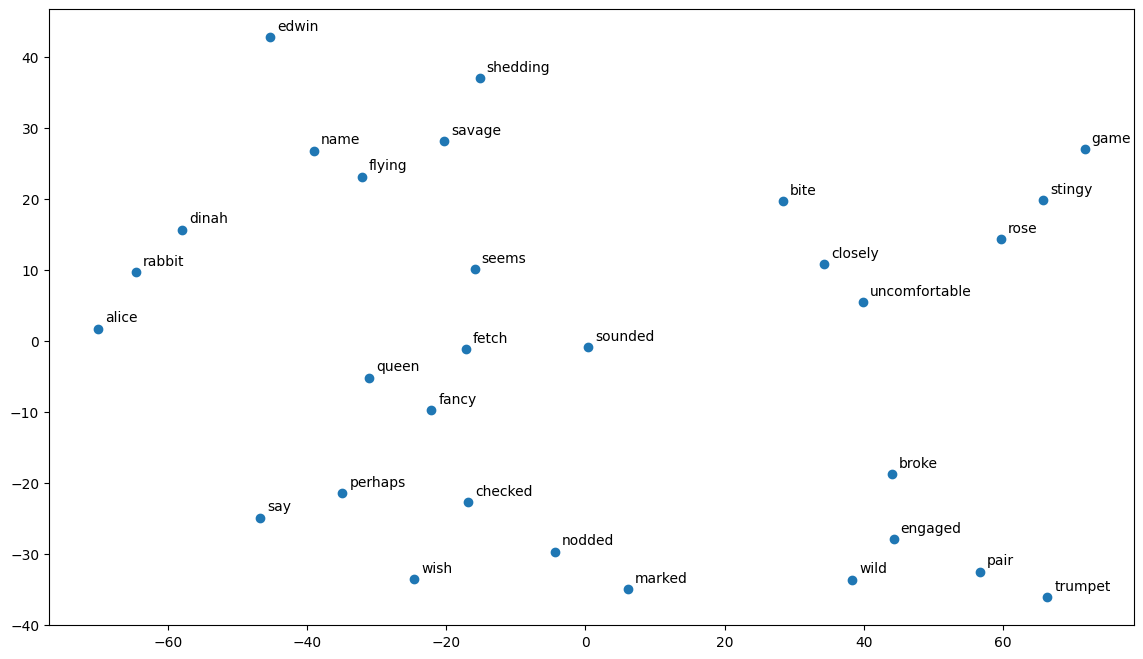

In [37]:
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Continuous Bag Of Words (CBOW) model

In [38]:
import gensim
# using the Word2Vec model from gensim
from gensim.models import Word2Vec

In [39]:
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [40]:
train_set = brown.sents(categories=['news', 'editorial', 'reviews'])
train_set

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [41]:
cbow_model = gensim.models.Word2Vec(train_set, sg = 1)  #sg: 1=CBOW, 0=skip-gram

In [42]:
cbow_model.save('brown.embedding')
new_model = gensim.models.Word2Vec.load('brown.embedding')

In [43]:
len(cbow_model.wv['election'])

100

In [44]:
cbow_model.wv['university']

array([-0.0096535 ,  0.08014738,  0.09785272,  0.12935738, -0.04857565,
       -0.25503823,  0.00297989,  0.20709483, -0.23238921, -0.20052613,
       -0.0413908 , -0.28078717, -0.11023831,  0.19260609,  0.07524051,
        0.03213064,  0.18347502, -0.08172936,  0.00793028, -0.3324094 ,
        0.14261052, -0.05932682,  0.21299988,  0.03429701,  0.12950522,
        0.04674184, -0.1427982 ,  0.09623849, -0.08043   ,  0.12341335,
        0.19050455,  0.00517977,  0.1459361 , -0.2847045 ,  0.01610158,
        0.03222984,  0.09523229, -0.0077201 ,  0.0293845 , -0.27589312,
       -0.04311445,  0.04317784, -0.07104977,  0.00242764,  0.07004557,
       -0.08069443, -0.1597042 ,  0.05189556,  0.0081421 ,  0.14795515,
        0.05008942, -0.08717344, -0.15655178,  0.04602847, -0.12011387,
       -0.06519806,  0.11777349, -0.01754361, -0.08170521,  0.17803638,
       -0.02731295, -0.01882182,  0.13067202,  0.05619137, -0.30946034,
        0.11378235,  0.12892097,  0.12564531, -0.1815385 ,  0.22

In [47]:
cbow_model.wv.similarity('university','campus')

KeyError: "Key 'campus' not present"

In [48]:
from nltk.data import find
nltk.download('word2vec_sample')

# using the pre-trained model from gensim
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
pretrained_cbow_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [50]:
pretrained_cbow_model.most_similar(positive=['woman','king'], negative=['man'], topn = 1)

[('queen', 0.7118193507194519)]

In [51]:
pretrained_cbow_model.most_similar(positive=['Paris','Germany'], negative=['Berlin'])

[('France', 0.7884091734886169),
 ('Belgium', 0.6197876930236816),
 ('Spain', 0.5664774179458618),
 ('Italy', 0.5654898881912231),
 ('Switzerland', 0.560969352722168),
 ('French', 0.5420509576797485),
 ('Europe', 0.5260106325149536),
 ('Netherlands', 0.5180178880691528),
 ('Morocco', 0.5137787461280823),
 ('Austria', 0.4871768653392792)]

In [52]:
pretrained_cbow_model.doesnt_match(['class', 'cafeteria', 'project', 'lab', 'assignment', 'beach'])

'beach'

## Which model is better?

**It depends on the problem!**

*   **Skip-Gram works well with small datasets, and can better represent rare words.**

Is it important for our model to represent less frequent words? then we should choose Skip-Gram.

Skip Gram finds the neighbors of a word.

Skipgram is good at capturing semantic relations, *pen and paper*

*   **CBOW is found to train faster than Skip-Gram, and can better represent more frequent words.**

What if we dont have much time to train and rare words are not that important for our solution? Then we should choose CBOW.

CBOW mostly finds the probability of a word occurring in a context.

CBOW learns better syntactic relations(morphologically similar words), *pen and pens*

# using BERT

In [ ]:
# Also check out : https://colab.research.google.com/github/sejas/pytorch-pos-tagging/blob/master/2%20-%20Fine-tuning%20Pretrained%20Transformers%20for%20PoS%20Tagging.ipynb
# Huggingface fine-tuning tutorial : https://huggingface.co/docs/transformers/en/training#fine-tune-a-pretrained-model

### fine-tuning BERT

In [ ]:
!pip install datasets transformers[torch] accelerate evaluate

from transformers import AutoTokenizer, AutoModelForSequenceClassification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
from datasets import load_dataset

dataset = load_dataset("rotten_tomatoes")
dataset["train"][4]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

{'text': "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .",
 'label': 1}

In [ ]:
# import BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# tokenizer supports multiple tokens such as [CLS], [PAD], [UNK] which also have a unique token id reserved to them
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token

print("special tokens :",init_token, pad_token)

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)

print("special token ids :",init_token_idx, pad_token_idx)

special tokens : [CLS] [PAD]
special token ids : 101 0


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch"
    )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.435700,0.475071,0.815197
2,0.311500,0.647446,0.826454
3,0.131500,0.832222,0.831144


TrainOutput(global_step=3201, training_loss=0.30626265118547397, metrics={'train_runtime': 2488.6767, 'train_samples_per_second': 10.283, 'train_steps_per_second': 1.286, 'total_flos': 6733011906662400.0, 'train_loss': 0.30626265118547397, 'epoch': 3.0})

### word embeddings from BERT

In [ ]:
from transformers import AutoModel
model = AutoModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

In [ ]:
import torch

text = "I want to extract word embeddings for this sentence"
tokens = tokenizer.tokenize(text, add_special_tokens = True)
input_ids = tokenizer.convert_tokens_to_ids(tokens)
ids_tensor = torch.tensor([input_ids])

print(tokens)
print(input_ids)

['[CLS]', 'I', 'want', 'to', 'extract', 'word', 'em', '##bed', '##ding', '##s', 'for', 'this', 'sentence', '[SEP]']
[101, 146, 1328, 1106, 16143, 1937, 9712, 4774, 3408, 1116, 1111, 1142, 5650, 102]


In [ ]:
# input_ids = torch.tensor(input_ids).unsqueeze(0)
model.eval()
with torch.no_grad():
    outputs = model(ids_tensor)
    embeddings = outputs.last_hidden_state[0]

In [ ]:
print("number of tokens in input text : "+ str(len(embeddings)))
print("length of each embedding : "+str(len(embeddings[0])))
print(embeddings)

number of tokens in input text : 14
length of each embedding : 768
tensor([[-0.3888,  0.3156, -0.0341,  ..., -0.0951,  0.3632,  0.4736],
        [-0.1601,  0.3209,  0.0847,  ...,  0.1099,  0.2677,  0.3222],
        [ 0.1526,  0.2606,  0.3678,  ...,  0.4205,  0.0882,  0.3715],
        ...,
        [ 0.0981, -0.0181,  0.1564,  ...,  0.3170,  0.2075,  0.3420],
        [-0.3648, -0.0366, -0.5980,  ...,  0.3655,  0.2273, -0.1430],
        [ 0.3281,  0.3452, -0.5192,  ...,  0.2421, -0.5764, -0.0823]])


# Sentence embeddings using Universal Sentence Encoder (USE)

In [53]:
import tensorflow as tf
import tensorflow_hub as hub
from scipy.spatial import distance

In [54]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [55]:
sentences = [
    ["Many people eat cereal for breakfast"],
    ["Chia seed pudding is a healthy breakfast compared to cereal"],
    ["Raju prefers fruitloops and granola with almond or oat milk in the morning"],
    ["Jim goes to the gym and exercises four days in a week"],
    ["This is a marvelous scientific breakthrough!"]
    ]

In [56]:
embeddings = []
for sent in sentences:
  sent_embedding = model(sent)
  embeddings.extend(sent_embedding)
len(embeddings)

5

In [57]:
len(embeddings[0])

512

In [58]:
similarity_score = 1-distance.cosine(embeddings[0],embeddings[1])
similarity_score

0.5825902819633484

In [59]:
similarity_score = 1-distance.cosine(embeddings[0],embeddings[2])
similarity_score

0.41707366704940796

In [60]:
similarity_score = 1-distance.cosine(embeddings[0],embeddings[3])
similarity_score

0.0826021134853363

In [61]:
similarity_score = 1-distance.cosine(embeddings[0],embeddings[4])
similarity_score

-0.006531427148729563

# Further Reading

[Sentence Transformers](https://www.sbert.net/)

[Models (feature extraction) in HuggingFace](https://huggingface.co/models?pipeline_tag=feature-extraction&sort=trending)